In [1]:
import pandas as pd
from langdetect import detect
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot

In [2]:
lem = WordNetLemmatizer() #create lemmatizer

In [3]:
dictionary = pd.read_csv('../data/processedDict.csv')
dictionary

,word,cat_lev1,cat_lev2,cat_lev3,ndf
0,information,business,professional_conduct_host,advice,0.008904
1,recommendations,business,professional_conduct_host,advice,0.008375
2,tips,business,professional_conduct_host,advice,0.008399
3,advice,business,professional_conduct_host,advice,0.007568
4,suggestions,business,professional_conduct_host,advice,0.007580
...,...,...,...,...,...
347,talking,social,social_interaction,talking,0.001961
348,chatting,social,social_interaction,talking,0.001408
349,moments,social,social_interaction,talking,0.001155
350,chats,social,social_interaction,talking,0.000553


In [4]:
filepath = '../data/en_reviews/brazil_en.csv'
reviews = pd.read_csv(filepath)

# reviews = reviews['date']
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion
0,17878,64852,2010-07-15,135370,Tia,This apartment is in a perfect location -- two...,en,0.055703
1,17878,76744,2010-08-11,10206,Mimi,we had a really great experience staying in Ma...,en,0.045307
2,17878,91074,2010-09-06,80253,Jan,Staying in Max appartment is like living in a ...,en,0.064972
3,17878,137528,2010-11-12,230449,Orene,In general very good and reasonable price.\r\n...,en,0.035503
4,17878,147594,2010-12-01,219338,David,The apt was nice and in a great location only ...,en,0.060345
...,...,...,...,...,...,...,...,...
80745,39864187,566446623,2019-11-19,93480623,Kim,Rodrigo‘s apartment was located in a great are...,en,0.060484
80746,39873863,561018925,2019-11-08,156300155,Alfie,Place is nice and clean. Close to the beach a...,en,0.059603
80747,39886303,566017607,2019-11-18,10587665,Fernando,Great apartment! Modern and stylish... good ta...,en,0.054545
80748,39897049,563308292,2019-11-12,102264039,Jean-Louis,Luis is a really good host.\nHe is very attent...,en,0.066986


In [5]:
# reviews = reviews[(reviews['date'] > '2010-01-01') & (reviews['date'] < '2011-01-01')]
# reviews.info()
# reviews['date'] = pd.to_datetime(reviews['date'])
# start_date = '2010-01-01'
# end_date = '2011-01-01'
# mask = (reviews['date'] > start_date) & (reviews['date'] <= end_date)
# reviews = reviews.loc[mask]
# reviews


In [6]:
def logTermFrequency(word, review):
    totalNumberOfWords = review.split()
#     print(totalNumberOfWords)
#     print(len(totalNumberOfWords))
    totalNumberOfWords = len(totalNumberOfWords)
#     print("totalNumberofWords:",totalNumberOfWords)
    numberOfWord = review.count(word)
#     print("numberOfWord:", word, numberOfWord)
    if numberOfWord == 0:
        return 0;
    result = math.log(totalNumberOfWords / numberOfWord)
#     result = numberOfWord / totalNumberOfWords
#     print("result:",result)
    return result
    
    

In [7]:
def adoptionForOneReview(category, review, dictionary):
    nominator = 0
    denominator = 0
    dictionaryWords = dictionary[(dictionary['cat_lev1'] == category)]
    dictionaryWords = dictionaryWords['word']
#     print(dictionaryWords)
#     print(review)
    for word in dictionaryWords:
        nominator = nominator + logTermFrequency(word, review)
    reviewWords = review.split()
#     print(reviewWords)
    checkRepetitions = []
    for word in reviewWords:
        if word in checkRepetitions:
#             print(checkRepetitions)
#             print(word)
            continue;
        denominator = denominator + logTermFrequency(word, review)
#         print(denominator)
        checkRepetitions.append(word)
#     print(nominator)
#     print(denominator)
    if denominator == 0:
#         print("whyyyyyyyyyyyyyyyyyyyyyyyy!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!11")
        return 0;
#     print("denominator:", denominator)
    adoption = nominator / denominator
    adoption = adoption * 100
    if(adoption == 0):
#         print("check")
        return 1;
#     print(adoption)
    return adoption

In [8]:
# oneReviewForTest = reviews['comments'][0]
# print(oneReviewForTest)
# check = adoptionForOneReview('business', oneReviewForTest, dictionary)
# check

# oneReviewForTest
# check2 = logTermFrequency('information', oneReviewForTest)
# check2

In [9]:
def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate):
    adoption = 1
#     print(setOfReviews)
    numOfReviews = len(setOfReviews)
#     print(numOfReviews)
    minimumAdotpion = 1
    mask = (setOfReviews['date'] > startDate) & (setOfReviews['date'] < endDate)
    setOfReviews = setOfReviews.loc[mask]
#     print(setOfReviews)
    
#     print(numOfReviews)
#     print(setOfReviews)
    setOfReviews = setOfReviews['comments'][:100]
    numOfReviews = len(setOfReviews)
#     print(setOfReviews)
    for review in setOfReviews:
#         print(review)
        adoptionValue = adoptionForOneReview(category, review, dictionary)
        
        if adoptionValue == 0:
            continue;
        if (minimumAdotpion > adoptionValue) and (adoptionValue != 0) :
            minimumAdotpion = adoptionValue
#             print(minimumAdotpion)
        adoption = adoption * adoptionValue
#         print(adoption)
#     print(adoption)
    adoption = adoption + minimumAdotpion
    adoption = np.power(adoption, (1 / numOfReviews))
    adoption = adoption - minimumAdotpion
    return adoption

In [10]:
# oneReviewForTest = reviews
# print(reviews['date'])
# for2010 = adoptionForSetOfReviews('business', reviews, dictionary, '2010-01-01', '2011-01-01')
for2011 = adoptionForSetOfReviews('business', reviews, dictionary, '2011-01-01', '2012-01-01')
# for2012 = adoptionForSetOfReviews('business', reviews, dictionary, '2012-01-01', '2013-01-01')
for2013 = adoptionForSetOfReviews('business', reviews, dictionary, '2013-01-01', '2014-01-01')
for2014 = adoptionForSetOfReviews('business', reviews, dictionary, '2014-01-01', '2015-01-01')
for2015 = adoptionForSetOfReviews('business', reviews, dictionary, '2015-01-01', '2016-01-01')
for2016 = adoptionForSetOfReviews('business', reviews, dictionary, '2016-01-01', '2017-01-01')
for2017 = adoptionForSetOfReviews('business', reviews, dictionary, '2017-01-01', '2018-01-01')
for2018 = adoptionForSetOfReviews('business', reviews, dictionary, '2018-01-01', '2019-01-01')
for2019 = adoptionForSetOfReviews('business', reviews, dictionary, '2019-01-01', '2020-01-01')

# print(for2010)
print(for2011)
# print(for2012)
print(for2013)
print(for2014)
print(for2015)
print(for2016)
print(for2017)
print(for2018)
print(for2019)




17.322419989126505
19.770158822165616
20.791095592351923
22.24406085952207
21.272836526874322
18.90756129998499
15.716433455094993
16.827784070236163


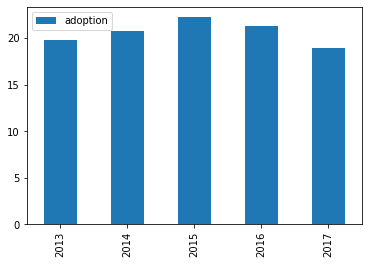

In [11]:
x_axis = [for2013, for2014, for2015, for2016, for2017]
df = pd.DataFrame(x_axis, index = ['2013', '2014', '2015', '2016', '2017'], columns = ['adoption'])
df
df.plot.bar()

In [12]:
for2013 = adoptionForSetOfReviews('social', reviews, dictionary, '2013-01-01', '2014-01-01')
for2014 = adoptionForSetOfReviews('social', reviews, dictionary, '2014-01-01', '2015-01-01')
for2015 = adoptionForSetOfReviews('social', reviews, dictionary, '2015-01-01', '2016-01-01')
for2016 = adoptionForSetOfReviews('social', reviews, dictionary, '2016-01-01', '2017-01-01')
for2017 = adoptionForSetOfReviews('social', reviews, dictionary, '2017-01-01', '2018-01-01')
for2018 = adoptionForSetOfReviews('social', reviews, dictionary, '2018-01-01', '2019-01-01')
for2019 = adoptionForSetOfReviews('social', reviews, dictionary, '2019-01-01', '2020-01-01')

# print(for2010)
# print(for2011)
# print(for2012)
print(for2013)
print(for2014)
print(for2015)
print(for2016)
print(for2017)
print(for2018)
print(for2019)




2.777922923353336
3.3628915553970784
3.0062923162749815
3.4024818397048504
2.784499002066635
3.7984121943861835
2.627148352411242


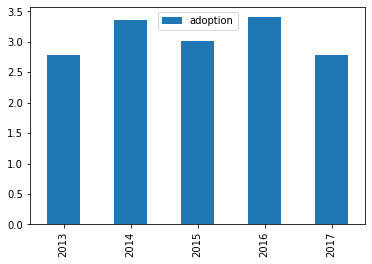

In [13]:
x_axis = [for2013, for2014, for2015, for2016, for2017]
df = pd.DataFrame(x_axis, index = ['2013', '2014', '2015', '2016', '2017'], columns = ['adoption'])
df
df.plot.bar()